In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import random
pd.set_option('display.max_columns', None)
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/512_project/data/validate_data.csv')
df

,state,county,COUNTYFP,date,new_cases,Face_Masks_Required_in_Public,mask_use
0,Georgia,Wayne,13305,2020-04-15,6.0,0.0,0.7605
1,Georgia,Wayne,13305,2020-04-16,3.0,0.0,0.7605
2,Georgia,Wayne,13305,2020-04-17,0.5,0.0,0.7605
3,Georgia,Wayne,13305,2020-04-18,0.5,0.0,0.7605
4,Georgia,Wayne,13305,2020-04-19,0.0,0.0,0.7605
...,...,...,...,...,...,...,...
11675,West Virginia,Wayne,54099,2022-04-10,0.0,0.0,NaN
11676,West Virginia,Wayne,54099,2022-04-11,1.0,0.0,NaN
11677,West Virginia,Wayne,54099,2022-04-12,1.5,0.0,NaN
11678,West Virginia,Wayne,54099,2022-04-13,1.5,0.0,NaN


In [4]:
# use this array to label output by state title
validation_states_array_holder = df['state'].unique()
validation_states_array = []

for state in validation_states_array_holder:
  validation_states_array += [state] * 2

# Multivariate data preparation

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(0, len(sequences), n_steps):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), np.expand_dims(y, axis=1)

# Create a dataset

In [6]:
validate_np = df[['new_cases', 'Face_Masks_Required_in_Public', 'mask_use']].to_numpy()
validate_np.shape

(11680, 3)

# Create sequences of one year



In [7]:
seq_length = 365

In [8]:
X_validate, y_validate = split_sequences(validate_np, seq_length)

In [9]:
X_validate.shape

(32, 365, 2)

# Convert to Pytorch

In [10]:
# convert train and test data to tensors
X_validate = torch.tensor(X_validate, dtype=torch.float)
y_validate = torch.tensor(y_validate, dtype=torch.float)

In [11]:
X_validate.shape

torch.Size([32, 365, 2])

# Create an LSTM model

In [12]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features, seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_length = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.act1 = torch.nn.ReLU()
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden * self.seq_length, 1)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers, batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers, batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_length, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        x = self.act1(x)
        return self.l_linear(x)

# Validating

In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    print('Loading model at epoch', checkpoint['epoch'])
    model = MV_LSTM(checkpoint['n_features'], checkpoint['seq_length'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [14]:
mv_net = load_checkpoint('/content/drive/My Drive/512_project/models/model.pt')

Loading model at epoch 20


In [15]:
mv_net.init_hidden(X_validate.size(0))
mv_net.eval()
# get predictions
output = mv_net(X_validate) 

Here is the predicted mask usage for Wayne Counties (including Michigan)

In [16]:
y_pred = output.view(-1).detach().numpy()

In [17]:
y_pred[y_pred > 1] = 1
y_pred[y_pred < 0] = 0

Here is the actual mask usage for Wayne Counties (including Michigan)

In [18]:
y_true = y_validate.view(-1).detach().numpy()

In [19]:
df_output = pd.DataFrame({'State': validation_states_array, 'County':['Wayne'] * len(y_pred), 'Predicted Mask Usage': y_pred, 'True Mask Usage': y_true})
df_output

,State,County,Predicted Mask Usage,True Mask Usage
0,Georgia,Wayne,0.743439,0.76050
1,Georgia,Wayne,0.748327,NaN
2,Illinois,Wayne,0.718695,0.66950
3,Illinois,Wayne,0.483620,NaN
4,Indiana,Wayne,0.744180,0.63525
5,Indiana,Wayne,0.263822,NaN
6,Iowa,Wayne,0.715811,0.59500
7,Iowa,Wayne,1.000000,NaN
8,Kentucky,Wayne,0.749819,0.66150
9,Kentucky,Wayne,0.125460,NaN


# Visualize Results

In [20]:
x1 = [pd.to_datetime('2020-04-15'), pd.to_datetime('2021-04-15')]
x2 = [pd.to_datetime('2020-04-15'), pd.to_datetime('2021-04-15'), pd.to_datetime('2022-04-15')] 

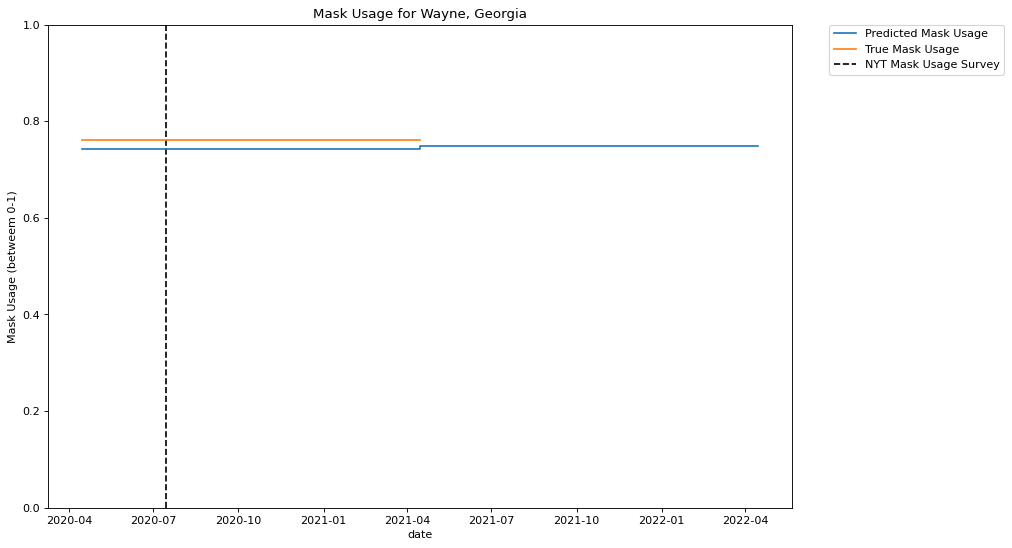

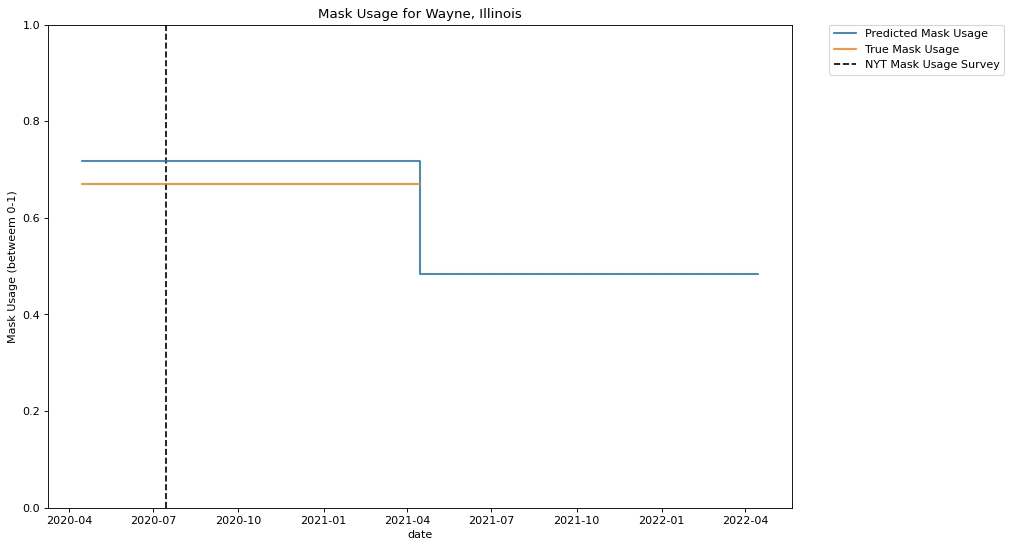

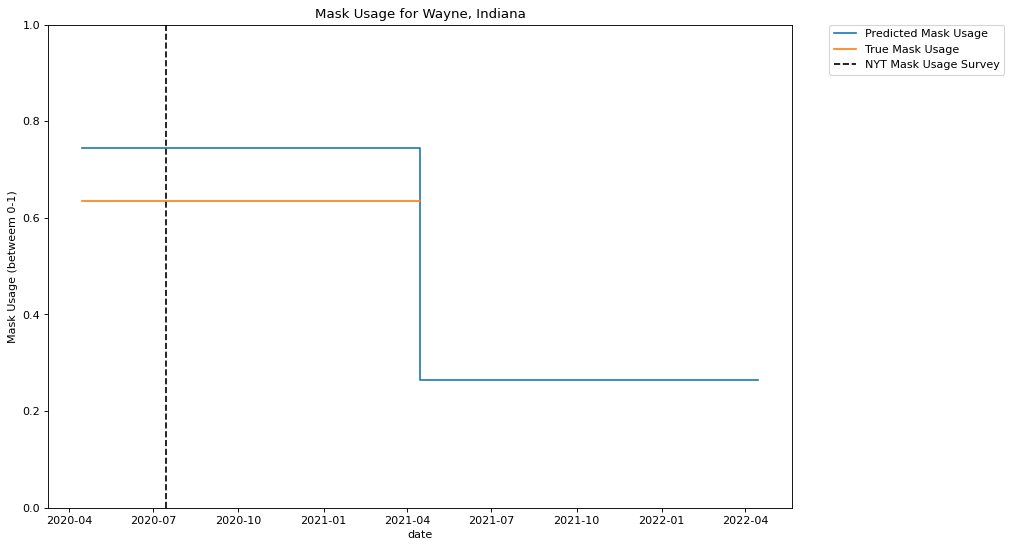

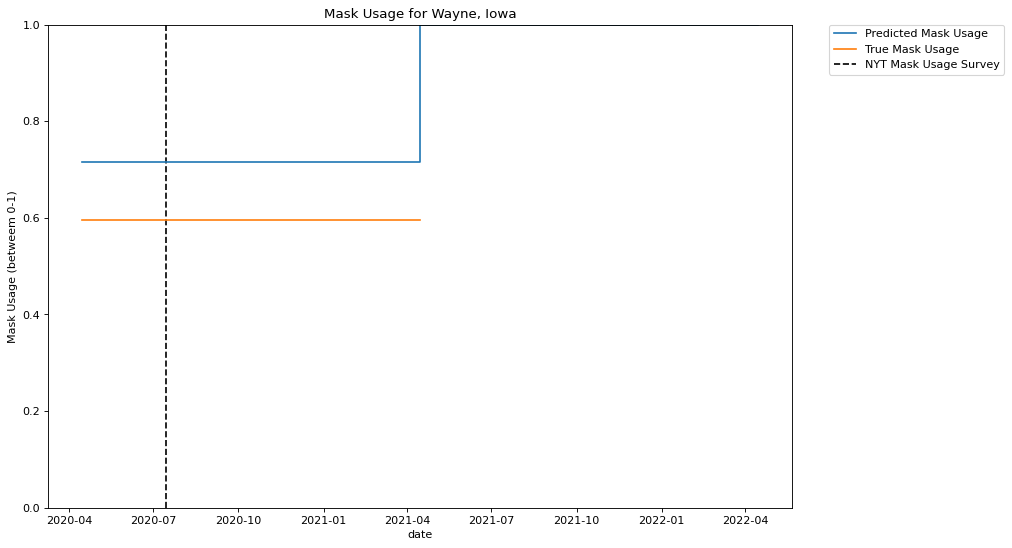

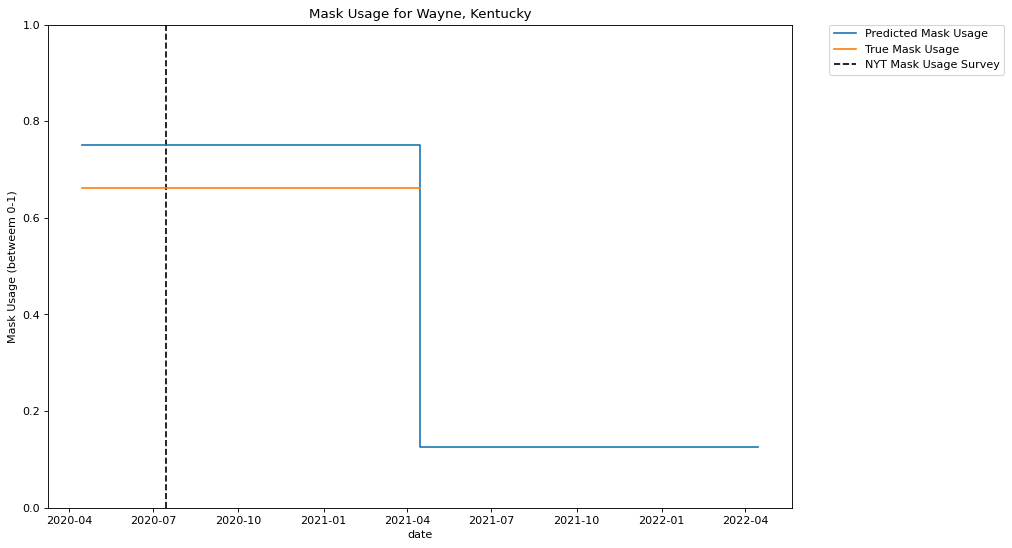

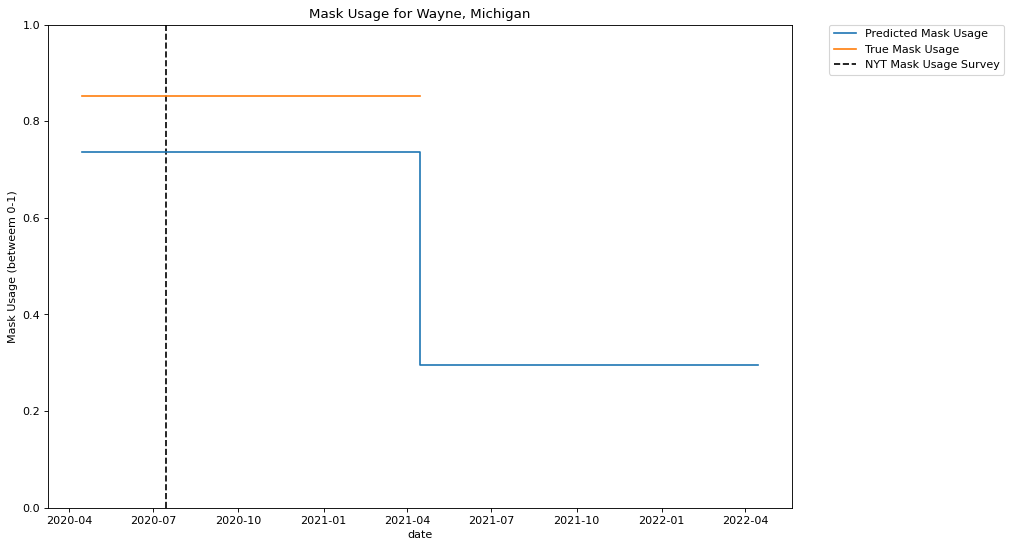

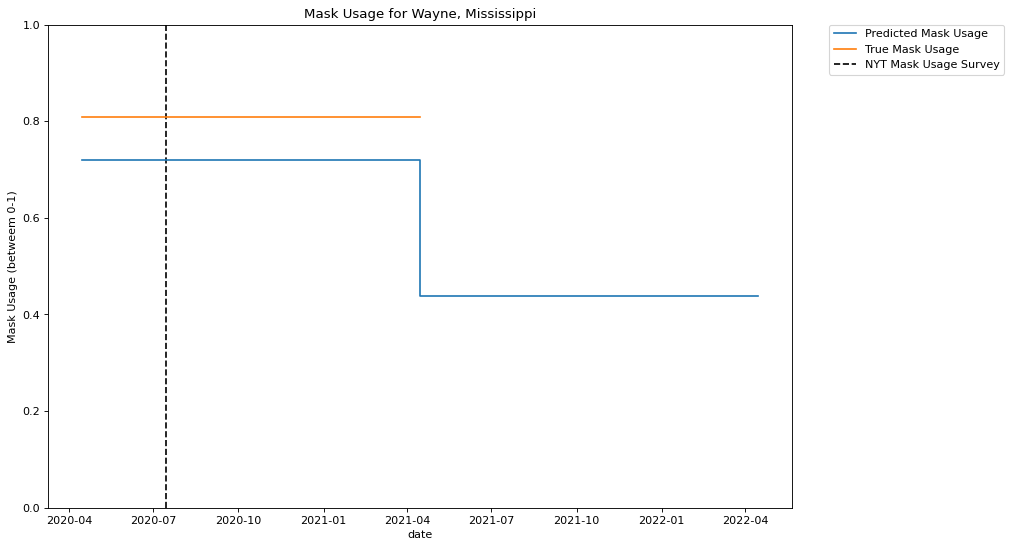

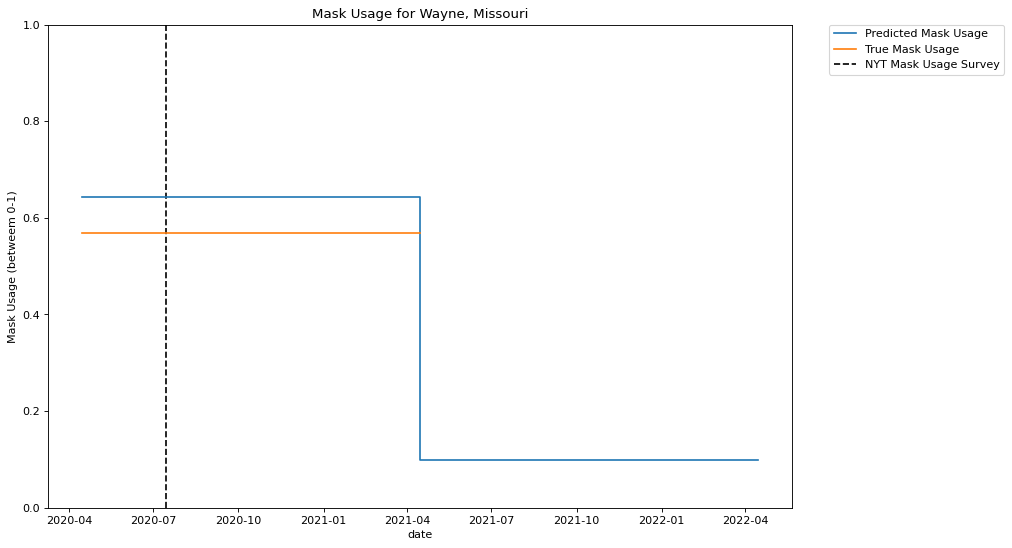

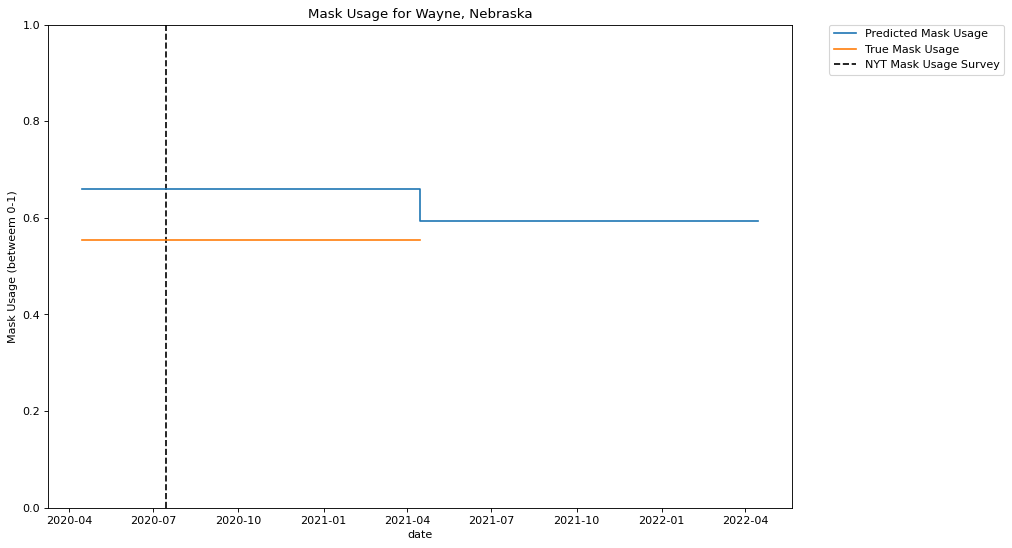

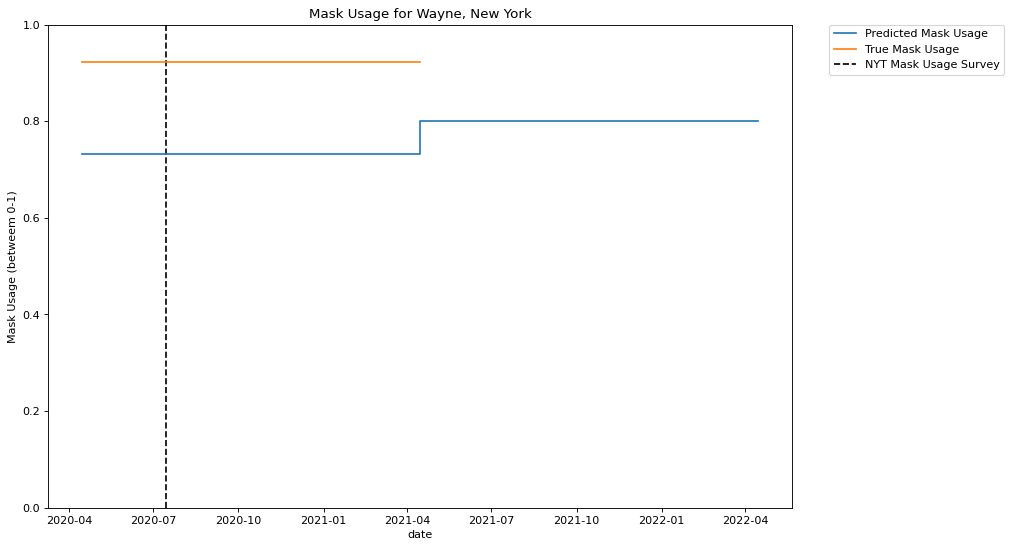

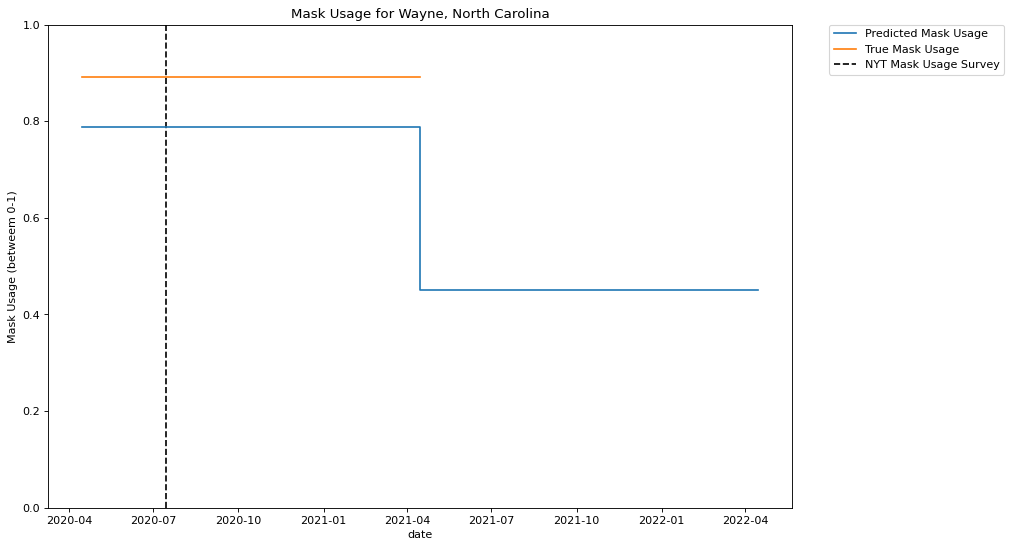

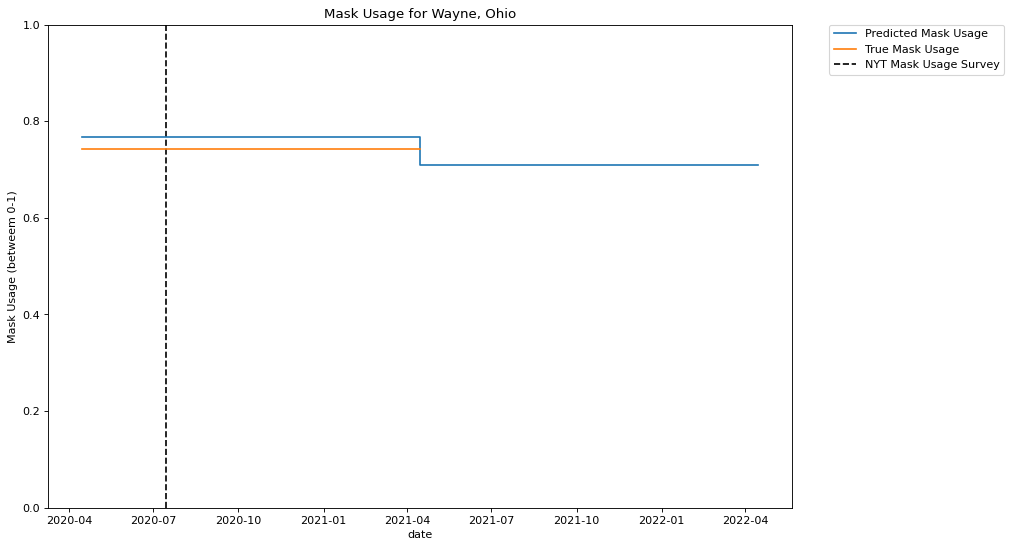

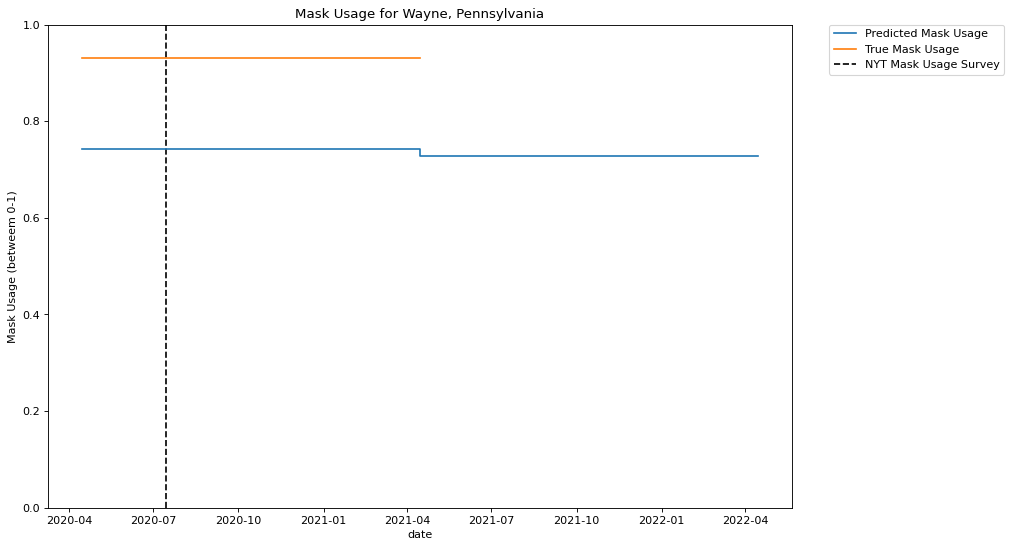

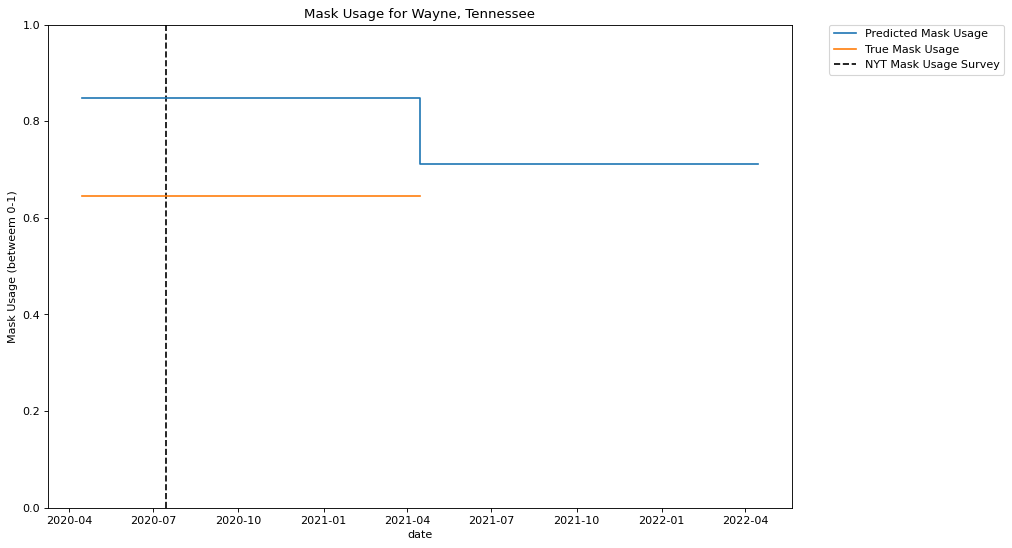

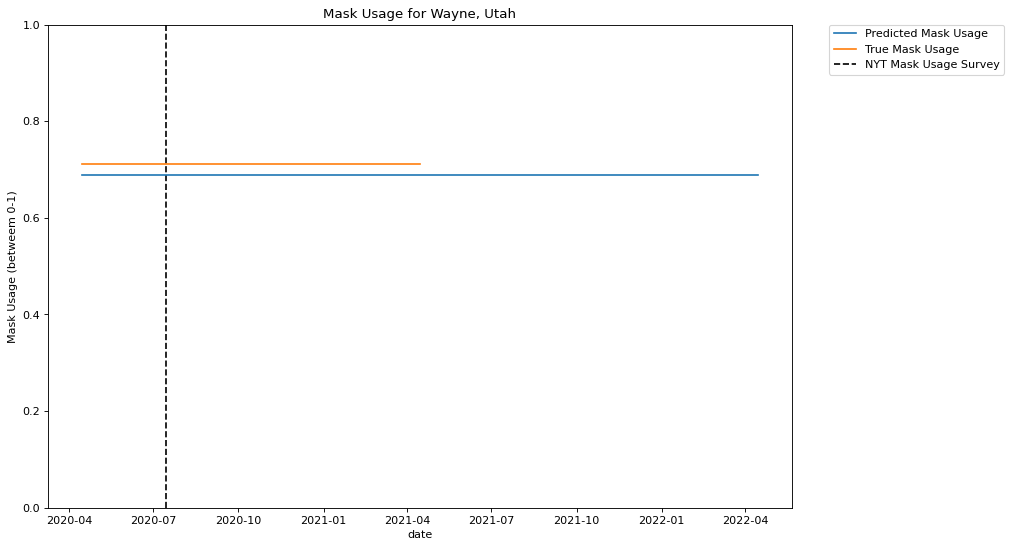

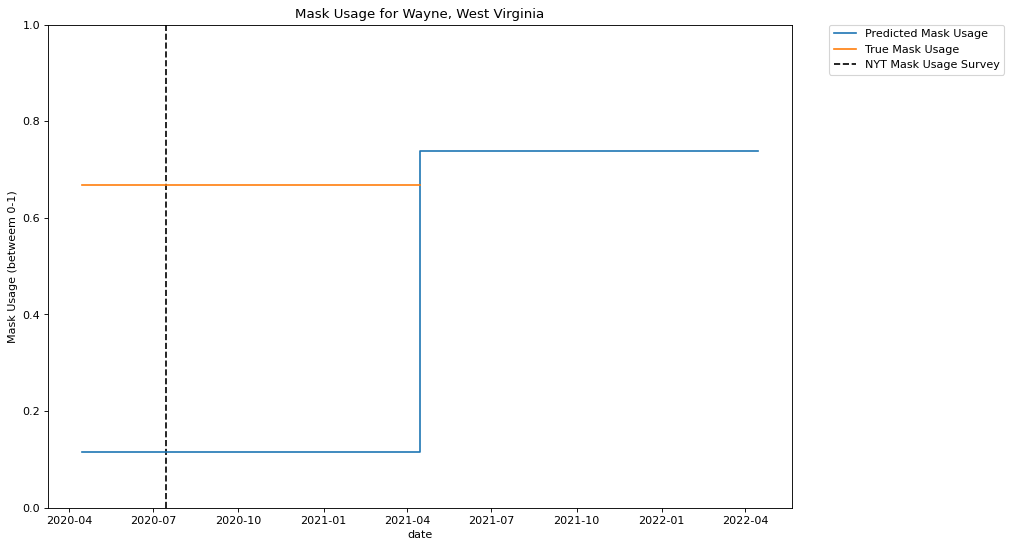

In [21]:
for i in range(0, len(y_pred) - 1, 2):
  pred = np.array([y_pred[i], y_pred[i], y_pred[i + 1]]) 
  actual = np.array([y_true[i], y_true[i]]) 

  figure(figsize=(12, 8), dpi=80)
  plt.ylim([0, 1])
  plt.step(x2, pred, label="Predicted Mask Usage")
    
  plt.step(x1, actual, label="True Mask Usage")
  plt.vlines(x = pd.to_datetime('2020-07-15'), ymin = 0, ymax = 1, 
             color = 'black', ls='--', label="NYT Mask Usage Survey")
  plt.xlabel("date")
  plt.ylabel("Mask Usage (betweem 0-1)")
  plt.title('Mask Usage for Wayne, {}'.format(validation_states_array[i]))
  plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
    
  # plt.fill_between(x, y, y1, color='green', alpha=0.5)
  plt.savefig('/content/drive/My Drive/512_project/outputted_images/Wayne, {}.png'.format(validation_states_array[i]), 
              bbox_inches='tight')
  plt.show()
  print('')